In [20]:
import sys
sys.path.append('/pl/active/banich/studies/Relevantstudies/abcd/data/clustering/analysis/')
sys.path.append('/pl/active/banich/studies/Relevantstudies/abcd/env/lib/python3.7/site-packages')

from functions import *
import shap
import xgboost
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from matplotlib import colors as plt_colors
import pandas as pd
from sklearn.metrics import pairwise_distances
from igraph import *

In [21]:
matched_subid = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/subj/matched_subid.csv')
matched_subid.columns = ['sub', 'SubID']

In [22]:
z_data = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/analysis/ClearMem_Z_Average.csv')
z_data = z_data[['SubID', 'z_ave', 'PSWQ_total', 'WBSI_total', 'RRS_total', 'RRS_depression', 'RRS_brooding', 'RRS_reflection']]
z_data = z_data.dropna()

from scipy.stats import zscore
z_data['br_z_ave'] = z_data['z_ave']
z_data.drop('z_ave', axis=1, inplace=True)
z_data['b_z_ave'] = (zscore(z_data['PSWQ_total']) + zscore(z_data['WBSI_total']) + zscore(z_data['RRS_brooding']))/3
z_data['brd_z_ave'] = (zscore(z_data['PSWQ_total']) + zscore(z_data['WBSI_total']) + zscore(z_data['RRS_brooding']) + zscore(z_data['RRS_reflection']) + zscore(z_data['RRS_depression']))/5

In [23]:
import glob
import pandas as pd
import re

# Define the pattern to match files
pattern = '/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/subj/sub*_sm_vector/sub*_sm_vector_*_all_ops.csv'

# Use glob to find all files that match the pattern
file_list = sorted(glob.glob(pattern))

# Initialize an empty list to store DataFrames
dataframes = []

for file in file_list:
    # Extract subject ID from the file path
    subject_id = re.search(r'sub(\d+)_', file).group(1)
    
    # Extract the part of the filename before '_all_ops'
    grad = re.search(r'_(g\d+)_all_ops', file).group(1)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file)
    
    # Add the subject ID as a new column
    df['SubID'] = subject_id
    
    # Add the 'grad' as a new column
    df['grad'] = grad
    
    # Append the DataFrame to the list
    dataframes.append(df)

# Combine all DataFrames into one, if necessary
combined_df = pd.concat(dataframes, ignore_index=True)

# Now 'combined_df' contains all data with a 'SubID' and 'grad' column indicating the subject ID and the gradient respectively.
# Adjusting the DataFrame by dropping and reordering columns as required
combined_df = combined_df.drop(['Unnamed: 0', 'sub'], axis=1, errors='ignore')  # errors='ignore' handles cases where these columns might not exist
combined_df = combined_df[['index', 'SubID', 'maintain', 'replace', 'suppress', 'clear', 'grad']]

# combined_df now includes the 'grad' column with the part of the filename you were interested in.

combined_df_g1 = combined_df.query('grad == "g1"').drop('grad', axis=1).reset_index(drop=True)
combined_df_g1.columns = ['index', 'SubID', 'maintain_g1', 'replace_g1', 'suppress_g1', 'clear_g1']

combined_df_g2 = combined_df.query('grad == "g2"').drop('grad', axis=1).reset_index(drop=True)
combined_df_g2.columns = ['index', 'SubID', 'maintain_g2', 'replace_g2', 'suppress_g2', 'clear_g2']

combined_df_g3 = combined_df.query('grad == "g3"').drop('grad', axis=1).reset_index(drop=True)
combined_df_g3.columns = ['index', 'SubID', 'maintain_g3', 'replace_g3', 'suppress_g3', 'clear_g3']

combined_all = pd.concat([combined_df_g1, 
                          combined_df_g2.drop(['index', 'SubID'], axis=1), 
                          combined_df_g3.drop(['index', 'SubID'], axis=1)], axis=1)

combined_all = combined_all[['index', 'SubID', 'maintain_g1', 'maintain_g2', 'maintain_g3', 'replace_g1', 'replace_g2', 'replace_g3', 
              'suppress_g1', 'suppress_g2', 'suppress_g3', 'clear_g1', 'clear_g2', 'clear_g3']]

wm_networks = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/rest/rest_gradients/wm_networks.csv')
wm_networks = wm_networks.reset_index()

combined_all = pd.merge(wm_networks, combined_all, on='index').sort_values(['SubID', 'index'])

combined_all.SubID = combined_all.SubID.astype(int)

In [24]:
combined_all = (pd.merge(matched_subid, combined_all, on='SubID')
               .drop('SubID', axis=1).rename({'sub':'SubID'}, axis=1))

In [26]:
def across_net_disp(subid):

    global combined_all

    df = combined_all.query(f'SubID == {subid}')

    import pandas as pd
    import numpy as np
    from scipy.spatial.distance import mahalanobis

    # List of operations
    operations = ['main', 'replace', 'suppress', 'clear']

    # Network codes and names mapping
    network_names = {
        1: 'vn',
        2: 'smn',
        3: 'fpcn',
        4: 'dmn'
    }

    # Initialize an empty DataFrame to store results
    results_df = pd.DataFrame()

    # Iterate over each operation
    for op in operations:
        # Iterate over all possible combinations of networks
        for net1 in range(1, 5):
            for net2 in range(net1 + 1, 5):
                # Filter data for each network based on operation
                df_network1 = df.query(f'Subtype == {net1}').filter(regex=f'{op}')
                df_network2 = df.query(f'Subtype == {net2}').filter(regex=f'{op}')

                # Calculate the mean vector for Network1 and Network2
                mu_network1 = df_network1.mean()
                mu_network2 = df_network2.mean()

                # Calculate the covariance matrix for Network1 and Network2
                cov_network1 = df_network1.cov()
                cov_network2 = df_network2.cov()

                # Calculate the average covariance matrix
                avg_cov = (cov_network1 + cov_network2) / 2

                if not avg_cov.empty:
                    inv_avg_cov = np.linalg.inv(avg_cov)

                    # Calculate the Mahalanobis distance between the two mean vectors using the average covariance matrix
                    distance = mahalanobis(mu_network1, mu_network2, inv_avg_cov)*-1

                    # Format result
                    sub1 = network_names[net1]
                    sub2 = network_names[net2]

                    # Prepare result for this combination and operation
                    result = pd.DataFrame([[subid, distance]], columns=['SubID', f'{op}_{sub1}_{sub2}_disp'])

                    # Append result to the results DataFrame
                    results_df = pd.concat([results_df, result], ignore_index=True)

    # Define a custom aggregation function that ignores NAs
    def first_non_na(series):
        return series.dropna().iloc[0] if not series.dropna().empty else np.nan

    results_df = results_df.groupby(['SubID'], as_index=False).agg(first_non_na)

    return results_df


In [27]:
across_net_disp_lists = [across_net_disp(i) for i in combined_all.SubID.unique()]
across_network_disp = pd.concat(across_net_disp_lists).reset_index(drop=True)
across_network_disp.shape

(55, 25)

In [28]:
across_network_disp.to_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/dispersion_data/derosa_task_across_network_dispersion.csv')

In [44]:
#across_network_disp

In [29]:
#sns.clustermap(across_network_disp.iloc[:, 1:].corr(), center=0, cmap='bwr')

In [46]:
import pandas as pd
from sklearn.preprocessing import power_transform

# Assuming sub_data is your DataFrame and filtered_data is already defined
# filtered_data = sub_data.filter(regex='disp')
# Filter columns based on regex
filtered_data = across_network_disp.filter(regex='disp')

# Apply Yeo-Johnson transformation
# Note: power_transform returns a numpy array, so we need to convert it back to a DataFrame
yeo_johnson_transformed_data = pd.DataFrame(power_transform(filtered_data, method='yeo-johnson'), columns=filtered_data.columns)

#yeo_johnson_transformed_data

import numpy as np
from scipy import stats

# Perform the Shapiro-Wilk test for normality
shapiro_test = stats.shapiro(yeo_johnson_transformed_data)

print(f"Shapiro-Wilk Test statistic: {shapiro_test.statistic}, p-value: {shapiro_test.pvalue}")

# Interpretation of the result
if shapiro_test.pvalue > 0.05:
    print("The data is likely normal (fail to reject H0)")
else:
    print("The data is likely not normal (reject H0)")


Shapiro-Wilk Test statistic: 0.9945168495178223, p-value: 0.00010954433673759922
The data is likely not normal (reject H0)


In [47]:
#across_network_disp_yeo = pd.concat([across_network_disp[['SubID']], yeo_johnson_transformed_data], axis=1)

In [48]:
def run_regression(data, target, y_vars):

    import pandas as pd
    import statsmodels.api as sm
    import statsmodels.formula.api as smf

    
         # Joining list elements with ' + '
    joined_vars = ' + '.join(y_vars)
    # Turning it into a list with a single string element
    new_y_vars = [joined_vars]

    formula = f'{target} ~ {new_y_vars}'
    formula = formula.replace("[", "").replace("]", "").replace("'", "")

    # Fit the regression model using the formula
    model = smf.ols(formula=formula, data=data).fit()

    # Print the full regression output
    summary = model.summary()

    var = pd.DataFrame(summary.tables[0].data).iloc[0,1]

    table1 = pd.DataFrame(summary.tables[0].data).iloc[2:4, 3:].T.assign(var = var)
    table1.columns = ['fstat', 'pval', 'var']
    table1 = table1[['var', 'fstat', 'pval']]

    table2_cols = pd.DataFrame(summary.tables[1].data).loc[0].to_list() + ['var']
    table2_cols[0] = 'parameter'
    table2 = pd.DataFrame(summary.tables[1].data).iloc[1:].assign(var = var)
    table2.columns = table2_cols
    table2 = table2[['var', 'parameter', 'coef', 'std err', 't', 'P>|t|']]


    df = pd.merge(table1, table2, how='outer', left_on='var', right_on='parameter')

    # Combine 'var_x' and 'var_y' into a new column 'var'
    df['var'] = df['var_x'].fillna(df['var_y'])

    # Drop the original 'var_x' and 'var_y' columns
    df.drop(columns=['var_x', 'var_y'], inplace=True)

    # Reorder columns to place 'var' at the front if desired
    cols = ['var'] + [col for col in df.columns if col != 'var']
    df = df[cols]
    df = df.assign(formula = formula)
    
    return df



def run_regression(data, target, y_vars, interaction=None):
    import pandas as pd
    import statsmodels.api as sm
    import statsmodels.formula.api as smf

    if interaction is not None:
        # Creating the formula with interaction terms if there are multiple y_vars
        if len(y_vars) > 1:
            joined_vars = ' * '.join(y_vars)
        else:
            joined_vars = y_vars[0]
        
        new_y_vars = [joined_vars]
        formula = f'{target[0]} ~ {joined_vars}'

    else:
        joined_vars = ' + '.join(y_vars)
        new_y_vars = [joined_vars]
        formula = f'{target[0]} ~ {joined_vars}'

    # Fit the regression model using the formula
    model = smf.ols(formula=formula, data=data).fit()

    # Print the full regression output
    summary = model.summary()

    var = pd.DataFrame(summary.tables[0].data).iloc[0, 1]

    table1 = pd.DataFrame(summary.tables[0].data).iloc[:4, 3:].T.assign(var=var)
    table1.columns = ['r2', 'adjr2', 'fstat', 'pval', 'var']
    table1 = table1[['var', 'r2', 'adjr2', 'fstat', 'pval']]

    table2_cols = pd.DataFrame(summary.tables[1].data).loc[0].to_list() + ['var']
    table2_cols[0] = 'parameter'
    table2 = pd.DataFrame(summary.tables[1].data).iloc[1:].assign(var=var)
    table2.columns = table2_cols
    table2 = table2[['var', 'parameter', 'coef', 'std err', 't', 'P>|t|']]

    df = pd.merge(table1, table2, how='outer', left_on='var', right_on='parameter')

    # Combine 'var_x' and 'var_y' into a new column 'var'
    df['var'] = df['var_x'].fillna(df['var_y'])

    # Drop the original 'var_x' and 'var_y' columns
    df.drop(columns=['var_x', 'var_y'], inplace=True)

    # Reorder columns to place 'var' at the front
    cols = ['var'] + [col for col in df.columns if col != 'var']
    df = df[cols]
    df = df.assign(formula=formula)

    return df


def regression_function(data, variable_list):

    import itertools

    # Given list
    variables = variable_list
    targets = [['brd_z_ave']]

    # Create a list to hold all combinations
    all_combinations = []

    # Generate combinations for each length from 1 to the length of the list
    for r in range(1, len(variables) + 1):
        combinations = list(itertools.combinations(variables, r))
        all_combinations.extend(combinations)

    # Convert each tuple to a list
    list_combinations = [list(item) for item in all_combinations]

    regression_combinations = []
    for i in targets:
        for j in list_combinations:
            regression_combinations.append(run_regression(data, i, j))

    output_regressions = pd.concat(regression_combinations)

    # List of columns to convert
    columns_to_convert = ['r2', 'adjr2', 'fstat', 'pval', 'coef', 'std err', 't', 'P>|t|']

    # Convert each specified column to numeric, handling non-numeric values by converting them to NaN
    for column in columns_to_convert:
        output_regressions[column] = pd.to_numeric(output_regressions[column], errors='coerce')

    return output_regressions

In [54]:
import pandas as pd
from itertools import combinations

# Assuming across_network_disp is a DataFrame containing the data

# Define the list of networks
networks = ['vn', 'smn', 'fpcn', 'dmn']

# Generate pairwise combinations
pairwise_combinations = ['{}_{}'.format(x[0], x[1]) for x in combinations(networks, 2)]

# Initialize an empty DataFrame to store row means
row_means_df = pd.DataFrame()

# Iterate over pairwise combinations
for combination in pairwise_combinations:
    # Filter rows based on the combination
    filtered_rows = across_network_disp.filter(regex=f'{combination}')
    # Calculate row means
    row_means = filtered_rows.mean(axis=1)
    # Assign column name
    column_name = f'{combination}_mean'
    # Store row means in the DataFrame
    row_means_df[column_name] = row_means

# Now row_means_df contains the row means for each combination
across_network_disp_means = pd.concat([across_network_disp[['SubID']], row_means_df], axis=1)

In [55]:
def run_regression(data, target, y_vars, interaction=None):
    import pandas as pd
    import statsmodels.api as sm
    import statsmodels.formula.api as smf

    if interaction is not None:
        # Creating the formula with interaction terms if there are multiple y_vars
        if len(y_vars) > 1:
            joined_vars = ' * '.join(y_vars)
        else:
            joined_vars = y_vars[0]
        
        new_y_vars = [joined_vars]
        formula = f'{target[0]} ~ {joined_vars}'

    else:
        joined_vars = ' + '.join(y_vars)
        new_y_vars = [joined_vars]
        formula = f'{target[0]} ~ {joined_vars}'

    # Fit the regression model using the formula
    model = smf.ols(formula=formula, data=data).fit()

    # Print the full regression output
    summary = model.summary()

    var = pd.DataFrame(summary.tables[0].data).iloc[0, 1]

    table1 = pd.DataFrame(summary.tables[0].data).iloc[:4, 3:].T.assign(var=var)
    table1.columns = ['r2', 'adjr2', 'fstat', 'pval', 'var']
    table1 = table1[['var', 'r2', 'adjr2', 'fstat', 'pval']]

    table2_cols = pd.DataFrame(summary.tables[1].data).loc[0].to_list() + ['var']
    table2_cols[0] = 'parameter'
    table2 = pd.DataFrame(summary.tables[1].data).iloc[1:].assign(var=var)
    table2.columns = table2_cols
    table2 = table2[['var', 'parameter', 'coef', 'std err', 't', 'P>|t|']]

    df = pd.merge(table1, table2, how='outer', left_on='var', right_on='parameter')

    # Combine 'var_x' and 'var_y' into a new column 'var'
    df['var'] = df['var_x'].fillna(df['var_y'])

    # Drop the original 'var_x' and 'var_y' columns
    df.drop(columns=['var_x', 'var_y'], inplace=True)

    # Reorder columns to place 'var' at the front
    cols = ['var'] + [col for col in df.columns if col != 'var']
    df = df[cols]
    df = df.assign(formula=formula)

    return df


def regression_function(data, variable_list, interaction):

    import itertools

    # Given list
    variables = variable_list
    targets = [['RRS_total'], ['PSWQ_total'], ['WBSI_total'], ['b_z_ave'], ['br_z_ave'], ['brd_z_ave']]

    # Create a list to hold all combinations
    all_combinations = []

    # Generate combinations for each length from 1 to the length of the list
    for r in range(1, len(variables) + 1):
        combinations = list(itertools.combinations(variables, r))
        all_combinations.extend(combinations)

    # Convert each tuple to a list
    list_combinations = [list(item) for item in all_combinations]

    regression_combinations = []
    for i in targets:
        for j in list_combinations:
            regression_combinations.append(run_regression(data, i, j, interaction))

    output_regressions = pd.concat(regression_combinations)

    # List of columns to convert
    columns_to_convert = ['r2', 'adjr2', 'fstat', 'pval', 'coef', 'std err', 't', 'P>|t|']

    # Convert each specified column to numeric, handling non-numeric values by converting them to NaN
    for column in columns_to_convert:
        output_regressions[column] = pd.to_numeric(output_regressions[column], errors='coerce')

    return output_regressions

In [56]:
across_network_disp_means_z = pd.merge(across_network_disp_means, z_data, on='SubID')

In [57]:
disp_mean_list = ['vn_smn_mean', 'vn_fpcn_mean', 'vn_dmn_mean', 'smn_fpcn_mean', 'smn_dmn_mean', 'fpcn_dmn_mean']
disp_mean_reg = regression_function(across_network_disp_means_z, disp_mean_list, interaction=None)

In [58]:
disp_mean_reg.query('pval < .05').query('var == "brd_z_ave"').formula.to_list()

[]

In [30]:
def net_ecc(subid):
    global combined_all

    df = combined_all.query(f'SubID == {subid}')

    import pandas as pd
    import numpy as np
    from scipy.spatial.distance import mahalanobis

    # List of operations
    operations = ['main', 'replace', 'suppress', 'clear']

    # Network codes and names mapping
    network_names = {
        1: 'vn',
        2: 'smn',
        3: 'fpcn',
        4: 'dmn'
    }

    # Initialize an empty DataFrame to store results
    results_df = pd.DataFrame()

    # Iterate over each operation
    for op in operations:
        # Filter data for each operation
        df_operation = df.filter(regex=f'Subtype|{op}')
        
        # Calculate the mean vector and covariance matrix for this operation
        operation_mean = df_operation.drop('Subtype', axis=1).mean()
        operation_cov = df_operation.drop('Subtype', axis=1).cov()
        inv_operation_cov = np.linalg.inv(operation_cov)

        for net_code, net_name in network_names.items():
            # Filter data for each network based on operation
            df_network = df_operation.query(f'Subtype == {net_code}').drop('Subtype', axis=1)

            distances = []

            for index, row in df_network.iterrows():
                # Calculate the Mahalanobis distance from the mean of the entire data
                distance = mahalanobis(row, operation_mean, inv_operation_cov)
                distances.append(distance)  # Square the distance to calculate eccentricity

            # Calculate the sum of squared distances
            eccentricity = sum(distances)

            # Prepare result for this network and operation
            result = pd.DataFrame([[subid, eccentricity]], columns=['SubID', f'{op}_{net_name}_eccentricity'])

            # Append result to the results DataFrame
            results_df = pd.concat([results_df, result], ignore_index=True)
            
     # Define a custom aggregation function that ignores NAs
    def first_non_na(series):
        return series.dropna().iloc[0] if not series.dropna().empty else np.nan

    results_df = results_df.groupby(['SubID'], as_index=False).agg(first_non_na)

    return results_df


In [31]:
def op_ecc(subid):
    global combined_all

    df = combined_all.query(f'SubID == {subid}')

    import pandas as pd
    import numpy as np
    from scipy.spatial.distance import mahalanobis

    # List of operations
    operations = ['main', 'replace', 'suppress', 'clear']

    # Initialize an empty DataFrame to store results
    results_df = pd.DataFrame()

    # Iterate over each operation
    for op in operations:
        # Filter data for each operation
        df_operation = df.filter(regex=f'{op}')
        
        # Calculate the mean vector and covariance matrix for this operation
        operation_mean = df_operation.mean()
        operation_cov = df_operation.cov()
        inv_operation_cov = np.linalg.inv(operation_cov)

        for net_code, net_name in network_names.items():
            # Filter data for each network based on operation
            df_network = df_operation.query(f'op == {net_code}').drop('Subtype', axis=1)

            distances = []

            for index, row in df_network.iterrows():
                # Calculate the Mahalanobis distance from the mean of the entire data
                distance = mahalanobis(row, operation_mean, inv_operation_cov)
                distances.append(distance)  # Square the distance to calculate eccentricity

            # Calculate the sum of squared distances
            eccentricity = sum(distances)

            # Prepare result for this network and operation
            result = pd.DataFrame([[subid, eccentricity]], columns=['SubID', f'{op}_{net_name}_eccentricity'])

            # Append result to the results DataFrame
            results_df = pd.concat([results_df, result], ignore_index=True)
            
     # Define a custom aggregation function that ignores NAs
    def first_non_na(series):
        return series.dropna().iloc[0] if not series.dropna().empty else np.nan

    results_df = results_df.groupby(['SubID'], as_index=False).agg(first_non_na)

    return results_df


In [32]:
net_ecc_lists = [net_ecc(i) for i in combined_all.SubID.unique()]
net_ecc = pd.concat(net_ecc_lists).reset_index(drop=True)

In [36]:
#net_ecc

In [37]:
net_ecc.to_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/dispersion_data/derosa_task_eccentricity.csv')

In [26]:
net_ecc_z = pd.merge(net_ecc, z_data, on='SubID')

In [27]:
#sns.clustermap(across_network_ecc.iloc[:, 1:].corr(), center=0, cmap='bwr', annot=True)

In [28]:
import pandas as pd
from itertools import combinations

# Assuming across_network_disp is a DataFrame containing the data

# Define the list of networks
networks = ['vn', 'smn', 'fpcn', 'dmn']


# Initialize an empty DataFrame to store row means
row_means_df = pd.DataFrame()

# Iterate over pairwise combinations
for combination in networks:
    # Filter rows based on the combination
    filtered_rows = net_ecc.filter(regex=f'{combination}')
    # Calculate row means
    row_means = filtered_rows.mean(axis=1)
    # Assign column name
    column_name = f'{combination}_mean_ecc'
    # Store row means in the DataFrame
    row_means_df[column_name] = row_means

# Now row_means_df contains the row means for each combination
net_ecc_means = pd.concat([net_ecc[['SubID']], row_means_df], axis=1)

net_ecc_means['overall_mean_ecc'] = net_ecc[['main_vn_eccentricity', 'replace_vn_eccentricity', 'suppress_vn_eccentricity', 'clear_vn_eccentricity', 'main_fpcn_eccentricity', 'replace_fpcn_eccentricity', 'suppress_fpcn_eccentricity', 'clear_fpcn_eccentricity', 'main_dmn_eccentricity', 'replace_dmn_eccentricity', 'suppress_dmn_eccentricity', 'clear_dmn_eccentricity']].mean(axis=1)


In [29]:
net_ecc_mean_z = pd.merge(net_ecc_means, z_data, on='SubID')

In [30]:
ecc_mean_list = ['vn_mean_ecc', 'smn_mean_ecc', 'fpcn_mean_ecc', 'dmn_mean_ecc']
ecc_mean_reg = regression_function(net_ecc_mean_z , ecc_mean_list, interaction=None)

In [31]:
ecc_mean_reg.query('pval < .05')

,var,r2,adjr2,fstat,pval,parameter,coef,std err,t,P>|t|,formula
0,PSWQ_total,0.103,0.084,5.309,0.0258,NaN,NaN,NaN,NaN,NaN,PSWQ_total ~ dmn_mean_ecc
0,PSWQ_total,0.143,0.105,3.754,0.0311,NaN,NaN,NaN,NaN,NaN,PSWQ_total ~ vn_mean_ecc + dmn_mean_ecc
0,PSWQ_total,0.129,0.090,3.327,0.0449,NaN,NaN,NaN,NaN,NaN,PSWQ_total ~ fpcn_mean_ecc + dmn_mean_ecc
0,PSWQ_total,0.162,0.105,2.832,0.0491,NaN,NaN,NaN,NaN,NaN,PSWQ_total ~ vn_mean_ecc + fpcn_mean_ecc + dmn...
0,b_z_ave,0.093,0.073,4.691,0.0355,NaN,NaN,NaN,NaN,NaN,b_z_ave ~ dmn_mean_ecc
0,b_z_ave,0.143,0.105,3.760,0.0309,NaN,NaN,NaN,NaN,NaN,b_z_ave ~ vn_mean_ecc + dmn_mean_ecc
0,br_z_ave,0.151,0.113,3.993,0.0253,NaN,NaN,NaN,NaN,NaN,br_z_ave ~ vn_mean_ecc + dmn_mean_ecc
0,brd_z_ave,0.162,0.125,4.344,0.0188,NaN,NaN,NaN,NaN,NaN,brd_z_ave ~ vn_mean_ecc + dmn_mean_ecc
0,brd_z_ave,0.162,0.105,2.841,0.0486,NaN,NaN,NaN,NaN,NaN,brd_z_ave ~ vn_mean_ecc + smn_mean_ecc + dmn_m...
0,brd_z_ave,0.164,0.107,2.882,0.0464,NaN,NaN,NaN,NaN,NaN,brd_z_ave ~ vn_mean_ecc + fpcn_mean_ecc + dmn_...


In [32]:
sub_disp_means_df = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/dispersion_data/dmn_derosa_task_network_dispersion_means.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/dispersion_data/dmn_derosa_task_network_dispersion_means.csv'

In [ ]:
sub_disp_ecc_means_df = pd.merge(sub_disp_means_df, net_ecc_mean_z, on='SubID')
sub_disp_ecc_means_df = pd.merge(across_network_disp_means, sub_disp_ecc_means_df, on='SubID')

In [ ]:
ecc_disp_mean_list = ['vn_mean_ecc', 'dmn_mean_ecc', 'dmn_mean', 'fpcn_mean', 'vn_mean','vn_dmn_mean', 'fpcn_dmn_mean']


In [ ]:
#sub_disp_ecc_means_df.to_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/analysis/sub_disp_ecc_means_z.csv', index=False)

In [ ]:
all_regressions = regression_function(sub_disp_ecc_means_df, ecc_disp_mean_list, interaction=None)

In [ ]:
(all_regressions.query('pval < .05')
 .query('var == "brd_z_ave"')
 .sort_values('fstat', ascending=False)
 .formula.to_list()
)

In [ ]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

formula = 'brd_z_ave ~ dmn_mean_ecc * dmn_mean * fpcn_mean * vn_mean'

# Fit the regression model using the formula
model = smf.ols(formula=formula, data=sub_disp_ecc_means_df).fit()

# Print the full regression output
summary = model.summary()
pd.DataFrame(summary.tables[0].data).iloc[3, 3:]

In [ ]:
from statsmodels.stats.anova import anova_lm

# Fit both models
model1 = smf.ols(formula='brd_z_ave ~ dmn_mean + vn_mean_ecc + dmn_mean_ecc', data=sub_disp_ecc_means_df).fit()
model2 = smf.ols(formula='brd_z_ave ~ dmn_mean_ecc * dmn_mean * fpcn_mean * vn_mean', data=sub_disp_ecc_means_df).fit()

# Perform ANOVA test
anova_results = anova_lm(model1, model2)
print(anova_results)

In [ ]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# Assuming sub_disp_ecc_means_df is your DataFrame

# Define the formula
formula1 = 'brd_z_avae ~ dmn_mean + vn_mean_ecc + dmn_mean_ecc'

formula2 = 'brd_z_ave ~ dmn_mean_ecc * dmn_mean * fpcn_mean * vn_mean'

formula3 = 'brd_z_ave ~ overall_mean'

# Fit the regression model using the formula
model1 = smf.ols(formula=formula1, data=sub_disp_ecc_means_df).fit()
model2 = smf.ols(formula=formula2, data=sub_disp_ecc_means_df).fit()
#model3 = smf.ols(formula=formula3, data=sub_disp_ecc_means_df).fit()

# Plotting the model
plt.figure(figsize=(12, 8))
plt.plot(sub_disp_ecc_means_df['brd_z_ave'], label='Actual')
plt.plot(model1.fittedvalues, label='dmn_mean + vn_mean_ecc + dmn_mean_ecc')
#plt.plot(model2.fittedvalues, label='dmn_mean dmn_mean_ecc * dmn_mean * fpcn_mean * vn_mean', color='green')
#plt.plot(model3.fittedvalues, label='over_mean', color='green')
plt.xlabel('Index')
plt.ylabel('brd_z_ave')
plt.title('Actual vs Predicted brd_z_ave')
plt.legend()
plt.show()


NameError: name 'model3' is not defined

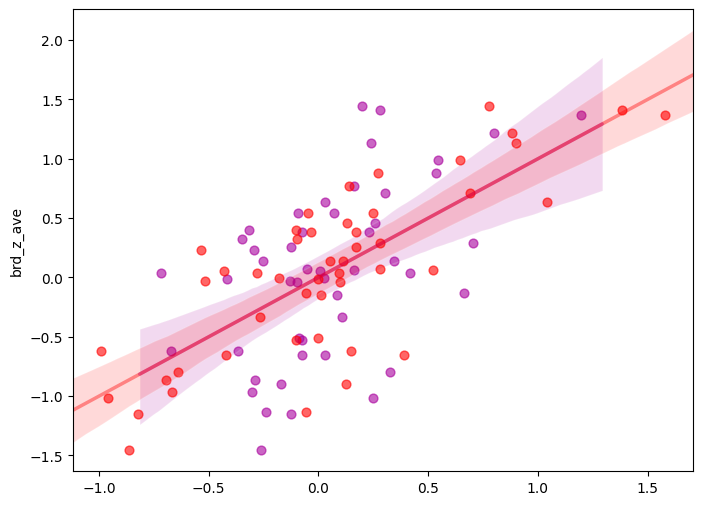

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Set the entire script to use Arial
plt.rcParams['font.family'] = 'sans-serif'

color = '#a8009d'
color2 = 'red'
color3 = 'green'
# Adjust figure size
fig, ax = plt.subplots(figsize=(8, 6))  # Increased figure size

# Scatter plot with regression line, ensuring CI is shown
sns.set_theme(style="white")

# Scatter plot with regression line modifications
sns.regplot(x=model1.fittedvalues, y=sub_disp_ecc_means_df['brd_z_ave'], ci=95,
            color=color, scatter_kws={'s': 40, 'alpha': 0.6}, truncate=False, ax=ax,
            line_kws={'linewidth': 2.5, 'alpha': 0.4})  # Set line width and transparency

sns.regplot(x=model2.fittedvalues, y=sub_disp_ecc_means_df['brd_z_ave'], ci=95,
            color=color2, scatter_kws={'s': 40, 'alpha': 0.6}, truncate=False, ax=ax,
            line_kws={'linewidth': 2.5, 'alpha': 0.4})  # Set line width and transparency

sns.regplot(x=model3.fittedvalues, y=sub_disp_ecc_means_df['brd_z_ave'], ci=95,
            color=color3, scatter_kws={'s': 40, 'alpha': 0.6}, truncate=False, ax=ax,
            line_kws={'linewidth': 2.5, 'alpha': 0.4})  # Set line width and transparency


#sns.regplot(x=f'{xvar}', y=f'{yvar}', data=data, fit_reg=False,
#            color='white', scatter_kws={'s': 20, 'alpha': .5}, truncate=False, ax=ax)

# Set axis labels
ax.set_xlabel('Network Dispersion Score', fontsize=15)
ax.set_ylabel('Thought Problems Score', fontsize=15)


In [ ]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# Assuming sub_disp_ecc_means_df is your DataFrame

# Define the formulas
formula1 = 'brd_z_ave ~ dmn_mean + vn_mean_ecc + dmn_mean_ecc'
formula2 = 'brd_z_ave ~ dmn_mean + vn_mean_ecc + dmn_mean_ecc + vn_mean*fpcn_mean'
formula3 = 'brd_z_ave ~ overall_mean'

# Fit the regression models using the formulas
model1 = smf.ols(formula=formula1, data=sub_disp_ecc_means_df).fit()
model2 = smf.ols(formula=formula2, data=sub_disp_ecc_means_df).fit()
model3 = smf.ols(formula=formula3, data=sub_disp_ecc_means_df).fit()

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plotting model 1
axes[0].scatter(sub_disp_ecc_means_df['dmn_mean'], sub_disp_ecc_means_df['brd_z_ave'], label='Actual', color='blue')
axes[0].scatter(sub_disp_ecc_means_df['dmn_mean'], model1.predict(), label='Predicted', color='red')
axes[0].set_xlabel('dmn_mean')
axes[0].set_ylabel('brd_z_ave')
axes[0].set_title('Model 1: Actual vs Predicted brd_z_ave')
axes[0].legend()

# Plotting model 2
axes[1].scatter(sub_disp_ecc_means_df['dmn_mean'], sub_disp_ecc_means_df['brd_z_ave'], label='Actual', color='green')
axes[1].scatter(sub_disp_ecc_means_df['dmn_mean'], model2.predict(), label='Predicted', color='orange')
axes[1].set_xlabel('dmn_mean')
axes[1].set_ylabel('brd_z_ave')
axes[1].set_title('Model 2: Actual vs Predicted brd_z_ave')
axes[1].legend()

# Plotting model 3
axes[2].scatter(sub_disp_ecc_means_df['overall_mean'], sub_disp_ecc_means_df['brd_z_ave'], label='Actual', color='purple')
axes[2].scatter(sub_disp_ecc_means_df['overall_mean'], model3.predict(), label='Predicted', color='yellow')
axes[2].set_xlabel('overall_mean')
axes[2].set_ylabel('brd_z_ave')
axes[2].set_title('Model 3: Actual vs Predicted brd_z_ave')
axes[2].legend()

plt.tight_layout()
plt.show()


In [ ]:
from statsmodels.stats.anova import anova_lm

# Fit both models
model1 = smf.ols(formula='brd_z_ave ~ dmn_mean + vn_mean_ecc + dmn_mean_ecc', data=sub_disp_ecc_means_df).fit()
model2 = smf.ols(formula='brd_z_ave ~ dmn_mean + vn_mean_ecc + dmn_mean_ecc + fpcn_mean*vn_mean', data=sub_disp_ecc_means_df).fit()

# Perform ANOVA test
anova_results = anova_lm(model1, model2)
print(anova_results)